In [2]:
# DataLoader
# Dataset 클래스에서 미니배치를 뽑아주는 DataLoader 클래스
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

In [10]:
# 반복자 : 원소를 반복하여 꺼내줌
# 파이썬의 반복자는 리스트나 튜플 등 여러 원소를 담고 있는 데이터 타입으로부터 데이터를 순차적으로 추출하는 기능 제공
t = [1,2,3]
x = iter(t)
next(x)     # 1
next(x)     # 2
next(x)     # 3
# next(x) : error 4번째 실행에서는 원소가 더는 존재하지 않기 때문에 stopiteration 예외 발생

3

In [12]:
# 파이썬에서 예시 반복자 구현
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()

        self.cnt += 1
        return self.cnt

# __iter__ : 자기 자신(self)을 반환하도록 함.
# __next__ : 다음 원소를 반환하도록 함

obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


In [ ]:
# dezero/dataloaders.py
import math
import random
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True, gpu=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)
        self.gpu = gpu

        self.reset()

    def reset(self):
        self.iteration = 0          # 반복 횟수 초기화
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))       # 데이터 shuffle
        else:
            self.index = np.arange(len(self.dataset))

    def __iter__(self):
        return self

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]

        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

    def next(self):
        return self.__next__()

    def to_cpu(self):
        self.gpu = False

    def to_gpu(self):
        self.gpu = True

In [15]:
# DataLoader 사용
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape)     # 훈련 데이터
        break

    for x, t in test_loader:
        print(x.shape, t.shape)     # 테스트 데이터
        break
    


(10, 2) (10,)
(10, 2) (10,)


In [17]:
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

epochs = []
train_losses = []
test_losses = []
train_accuracys = []
test_accuracys = []

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    print('epoch: {}'.format(epoch+1))    
    train_losses.append(sum_loss / len(train_set))
    train_accuracys.append(sum_acc / len(train_set))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():                          # 기울기 불필요 모드
        for x, t in test_loader:                    # 테스트용 미니배치 데이터
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)                  # 테스트 데이터의 인식 정확도
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set))) 
    epochs.append(epoch+1)
    test_losses.append(sum_loss / len(test_set))
    test_accuracys.append(sum_acc / len(test_set))


train loss: 1.0944, accuracy: 0.4033
epoch: 1
test loss: 1.0468, accuracy: 0.3267
train loss: 0.9882, accuracy: 0.4933
epoch: 2
test loss: 0.9729, accuracy: 0.4333
train loss: 0.9403, accuracy: 0.5133
epoch: 3
test loss: 0.8965, accuracy: 0.6233
train loss: 0.8820, accuracy: 0.5700
epoch: 4
test loss: 0.8771, accuracy: 0.5967
train loss: 0.8617, accuracy: 0.5600
epoch: 5
test loss: 0.8670, accuracy: 0.5867
train loss: 0.8313, accuracy: 0.5300
epoch: 6
test loss: 0.8654, accuracy: 0.6000
train loss: 0.8086, accuracy: 0.5833
epoch: 7
test loss: 0.7950, accuracy: 0.5600
train loss: 0.7948, accuracy: 0.5733
epoch: 8
test loss: 0.7921, accuracy: 0.5900
train loss: 0.7728, accuracy: 0.5500
epoch: 9
test loss: 0.7718, accuracy: 0.5300
train loss: 0.7643, accuracy: 0.5633
epoch: 10
test loss: 0.7796, accuracy: 0.5800
train loss: 0.7862, accuracy: 0.5600
epoch: 11
test loss: 0.7701, accuracy: 0.5633
train loss: 0.7914, accuracy: 0.5500
epoch: 12
test loss: 0.8218, accuracy: 0.6067
train loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

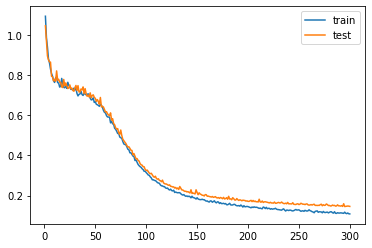

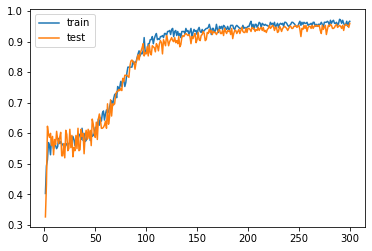

In [24]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.legend()
plt.show

plt.figure(2)
plt.plot(epochs, train_accuracys, label='train')
plt.plot(epochs, test_accuracys, label='test')
plt.legend()
plt.show
